Tiền xử lý & chuẩn hoá

PTBXL_ROOT = /home/cuong/root_data/Master/project_tinyml/database/physionet.org/files/ptb-xl/1.0.1
Batch shapes: (64, 1000, 1) (64, 2)
First sample mean/std: 1.525878978725359e-08 0.9999993443489075
Label count in batch [NORM, AF]: [53. 11.]
Batch shape: (64, 1000, 1) | labels in batch [NORM,AF] = [58  6]

Sample 0: label= NORM | mean(z)=0.000 std(z)=1.000 min=-1.330 max=6.846 
first 12 vals: [-0.216, -0.266, -0.423, -0.621, -0.703, -0.159,  2.878,  6.492,  3.538,
 -0.604, -0.332, -0.39 ]


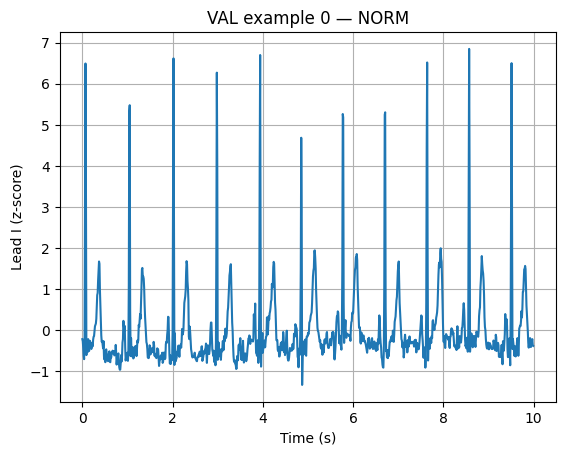


Sample 1: label= NORM | mean(z)=0.000 std(z)=1.000 min=-1.584 max=6.353 
first 12 vals: [ 0.851,  3.723,  5.733,  1.322, -0.229, -0.274, -0.297, -0.251, -0.493,
 -0.32 , -0.412, -0.343]


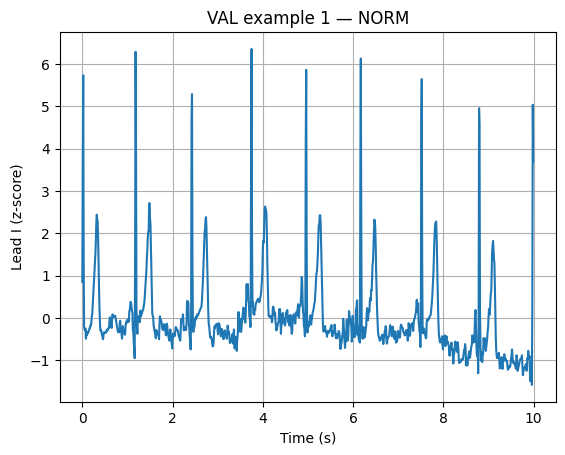


Sample 2: label= NORM | mean(z)=-0.000 std(z)=1.000 min=-1.951 max=6.210 
first 12 vals: [-0.094, -0.162, -0.238, -0.103, -0.128, -0.162, -0.035, -0.061, -0.077,
 -0.086, -0.111, -0.094]


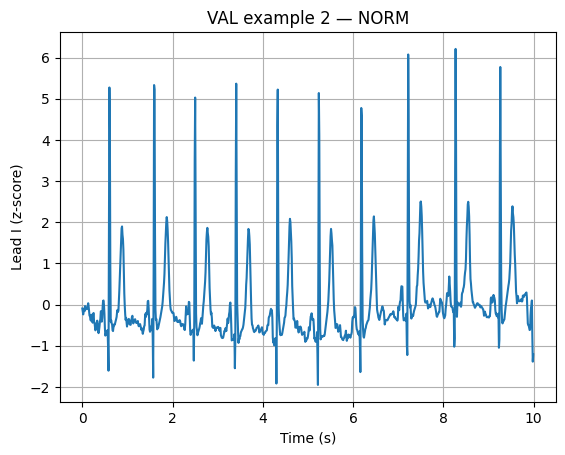

In [51]:
# =========================
# CELL T1' — Tiny generator dùng 100 Hz native (records100) — no resample
# =========================
import os, math, numpy as np, pandas as pd, wfdb
import tensorflow as tf

with open("ptbxl_root.txt") as f:
    PTBXL_ROOT = f.read().strip()
print("PTBXL_ROOT =", PTBXL_ROOT)

def _hr_to_lr(rel_hr: str) -> str:
    # ví dụ: records500/00000/00001_hr  ->  records100/00000/00001_lr
    return rel_hr.replace("records500", "records100").replace("_hr", "_lr")

class TinyLeadIGenerator(tf.keras.utils.Sequence):
    """
    Đọc Lead I @100Hz, 10s -> (1000,1), z-score theo cửa sổ.
    Ưu tiên records100/*_lr (100 Hz). Nếu thiếu, fallback: records500 + resample 500→100.
    Trả về ({'ecg': X}, y) với X:(B,1000,1), y:(B,2) one-hot [NORM,AF].
    """
    def __init__(self, csv_path, root, batch_size=64, shuffle=True):
        self.df = pd.read_csv(csv_path).dropna(subset=['filename_hr','label']).copy()
        self.root = root
        self.bs = int(batch_size)
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self): return math.ceil(len(self.indices) / self.bs)

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.indices)

    def _read_lead_I_100Hz_10s(self, rel_hr):
        rel_lr = _hr_to_lr(rel_hr)
        base_lr = os.path.join(self.root, rel_lr)

        def _zscore_10s(x):
            x = x[:1000] if x.shape[0] >= 1000 else np.pad(x, (0, 1000-x.shape[0]), mode='edge')
            m = float(x.mean()); s = float(x.std()) + 1e-7
            return ((x - m) / s).astype(np.float32)

        # ĐỌC 100 Hz (records100/*_lr)
        if not (os.path.exists(base_lr + ".hea") and os.path.exists(base_lr + ".dat")):
            raise FileNotFoundError(f"Không tìm thấy bản 100 Hz cho {rel_lr} (đã bỏ fallback).")

        rec = wfdb.rdrecord(base_lr, physical=True)   # <-- đổi base_lr
        names = [s.upper() for s in rec.sig_name]
        if 'I' not in names:
            raise ValueError(f"Thiếu lead I trong {rel_lr}. Leads: {names}")
        sig = rec.p_signal[:, names.index('I')].astype(np.float32)  # ~1000 mẫu
        return _zscore_10s(sig)

    def __getitem__(self, idx):
        ids = self.indices[idx*self.bs:(idx+1)*self.bs]
        rows = self.df.iloc[ids]

        X = np.zeros((len(rows), 1000, 1), dtype=np.float32)
        y = np.zeros((len(rows), 2), dtype=np.float32)

        for k, (_, r) in enumerate(rows.iterrows()):
            x = self._read_lead_I_100Hz_10s(r['filename_hr'])
            X[k, :, 0] = x
            y[k, int(r['label'])] = 1.0

        return {'ecg': X}, y

# Khởi tạo lại generators (giữ batch như trước)
BATCH_TINY = 64
train_tiny = TinyLeadIGenerator('split_train.csv', PTBXL_ROOT, batch_size=BATCH_TINY, shuffle=True)
val_tiny   = TinyLeadIGenerator('split_val.csv',   PTBXL_ROOT, batch_size=BATCH_TINY, shuffle=False)
test_tiny  = TinyLeadIGenerator('split_test.csv',  PTBXL_ROOT, batch_size=BATCH_TINY, shuffle=False)

# Smoke test
Xb, yb = train_tiny[0]
print("Batch shapes:", Xb['ecg'].shape, yb.shape)  # (B,1000,1), (B,2)
print("First sample mean/std:", float(Xb['ecg'][0].mean()), float(Xb['ecg'][0].std()))
print("Label count in batch [NORM, AF]:", yb.sum(axis=0))


# CELL V1 — Preview 3 inputs từ VAL (Lead I @100 Hz, 10s), đã z-score
import numpy as np, matplotlib.pyplot as plt

Xb, yb = val_tiny[0]                      # val_tiny đã shuffle=False nên ổn định
ecg = Xb['ecg']                           # shape: (B, 1000, 1)
labels = yb.argmax(axis=1)                # 0=NORM, 1=AF
t = np.arange(ecg.shape[1]) / 100.0       # 100 Hz → giây

print("Batch shape:", ecg.shape, "| labels in batch [NORM,AF] =", yb.sum(axis=0).astype(int))

for i in range(min(3, ecg.shape[0])):     # vẽ 3 mẫu đầu
    x = ecg[i, :, 0]
    print(f"\nSample {i}: label=", "AF" if labels[i]==1 else "NORM",
          "| mean(z)=%.3f std(z)=%.3f min=%.3f max=%.3f" % (x.mean(), x.std(), x.min(), x.max()),
          "\nfirst 12 vals:", np.array2string(x[:12], precision=3, separator=', '))
    plt.figure()
    plt.plot(t, x)                        # không set màu theo yêu cầu
    plt.xlabel("Time (s)"); plt.ylabel("Lead I (z-score)")
    plt.title(f"VAL example {i} — {'AF' if labels[i]==1 else 'NORM'}")
    plt.grid(True); plt.show()




tạo patient-wise split (train/val/test) và lưu ba file CSV

In [52]:
# CELL 2A — Auto-detect PTB-XL root + split patient-wise (CHỈ records100)
import os, re, pandas as pd, numpy as np

CSV_INDEX = "index_ptbxl_af_norm.csv"

# (1) Tự tìm thư mục cha của records500 (chuẩn PTB-XL) rồi kiểm tra records100 cũng tồn tại
CANDIDATE_STARTS = [
    ".", "..", "../..", "./ptbxl", "./PTBXL", "./PTB-XL", "./data", "/mnt/data", os.getcwd()
]

def find_ptbxl_root():
    seen = set()
    for start in CANDIDATE_STARTS:
        start = os.path.abspath(start)
        if not os.path.isdir(start) or start in seen:
            continue
        seen.add(start)
        for root, dirs, files in os.walk(start):
            if os.path.basename(root) == "records500":
                subs = [d for d in os.listdir(root) if re.fullmatch(r"\d{5}", d)]
                if len(subs) >= 1:
                    return os.path.dirname(root)
    return None

ptbxl_root = find_ptbxl_root()
if ptbxl_root is None:
    raise SystemExit(
        "❌ Không tìm thấy thư mục 'records500'. Hãy sửa CANDIDATE_STARTS hoặc đặt PTBXL_ROOT đúng.\n"
        "Ví dụ:\n"
        "  <PTBXL_ROOT>/records500/00000/00001_hr.hea (và .dat)"
    )
if not os.path.isdir(os.path.join(ptbxl_root, "records100")):
    raise SystemExit(
        f"❌ Tìm thấy PTBXL_ROOT={ptbxl_root} nhưng không có 'records100/'. "
        "Bộ notebook này yêu cầu records100 để chạy 100 Hz."
    )

print("✅ PTBXL_ROOT:", ptbxl_root)
with open("ptbxl_root.txt", "w") as f:
    f.write(ptbxl_root)

# (2) Load index
df = pd.read_csv(CSV_INDEX)
assert {'filename_hr','patient_id','age','sex','label'}.issubset(df.columns)
df = df[df['filename_hr'].notna()].copy()
df['patient_id'] = df['patient_id'].astype(int)
df['sex'] = df['sex'].astype(int)

# (2b) Chuẩn hoá đường dẫn 100 Hz (hr -> lr)
def _hr_to_lr(rel_hr: str) -> str:
    # records500/xxxxx/nnnnn_hr -> records100/xxxxx/nnnnn_lr
    return rel_hr.replace("records500", "records100").replace("_hr", "_lr")

df['filename_lr'] = df['filename_hr'].apply(_hr_to_lr)

# (3) Giữ lại CHỈ các hàng có file 100 Hz (records100/*_lr.{hea,dat})
def has_lr_files(row):
    p = os.path.join(ptbxl_root, row['filename_lr'])
    return os.path.exists(p + ".hea") and os.path.exists(p + ".dat")

mask = df.apply(has_lr_files, axis=1)
missing = int((~mask).sum())
print(f"🧹 Loại {missing} dòng không có bản 100 Hz (records100/*_lr)")
df = df[mask].reset_index(drop=True)
if len(df) == 0:
    raise SystemExit("❌ Không còn mẫu hợp lệ sau khi lọc records100.")

# (4) Patient-wise split: 80/10/10 (reproducible)
RNG = np.random.default_rng(42)
patients = df['patient_id'].unique()
RNG.shuffle(patients)
n = len(patients)
n_train = int(round(n*0.8)); n_val = int(round(n*0.1)); n_test = n - n_train - n_val

train_p = set(patients[:n_train])
val_p   = set(patients[n_train:n_train+n_val])
test_p  = set(patients[n_train+n_val:])

train_df = df[df['patient_id'].isin(train_p)].copy()
val_df   = df[df['patient_id'].isin(val_p)].copy()
test_df  = df[df['patient_id'].isin(test_p)].copy()

# (5) Sanity checks không giao thoa bệnh nhân
assert set(train_df['patient_id']).isdisjoint(val_df['patient_id'])
assert set(train_df['patient_id']).isdisjoint(test_df['patient_id'])
assert set(val_df['patient_id']).isdisjoint(test_df['patient_id'])

# (6) Save (giữ cả filename_hr để generator T1' tự map sang lr bên trong)
train_df.to_csv('split_train.csv', index=False)
val_df.to_csv('split_val.csv', index=False)
test_df.to_csv('split_test.csv', index=False)

def summary(d):
    vc = d['label'].value_counts().sort_index()
    af = int(vc.get(1,0)); nm = int(vc.get(0,0)); tot = max(1, af+nm)
    return len(d), d['patient_id'].nunique(), af, nm, af/tot

print("\n== Split summary (đã lọc records100) ==")
for name, d in [('TRAIN',train_df),('VAL',val_df),('TEST',test_df)]:
    rows, pats, af, nm, ratio = summary(d)
    print(f"{name}: rows={rows}, patients={pats}, AF={af}, NORM={nm}, AF_ratio={ratio:.3f}")

print("\nℹ️  Đã lưu PTBXL_ROOT vào 'ptbxl_root.txt' và các split CSV (*giữ cả filename_hr, có thêm filename_lr).")


✅ PTBXL_ROOT: /home/cuong/root_data/Master/project_tinyml/database/physionet.org/files/ptb-xl/1.0.1
🧹 Loại 0 dòng không có bản 100 Hz (records100/*_lr)

== Split summary (đã lọc records100) ==
TRAIN: rows=8783, patients=8040, AF=1194, NORM=7589, AF_ratio=0.136
VAL: rows=1081, patients=1005, AF=149, NORM=932, AF_ratio=0.138
TEST: rows=1114, patients=1005, AF=150, NORM=964, AF_ratio=0.135

ℹ️  Đã lưu PTBXL_ROOT vào 'ptbxl_root.txt' và các split CSV (*giữ cả filename_hr, có thêm filename_lr).


tạo generator Lead I @100 Hz, 10 s (1000×1), chuẩn hoá z-score theo từng cửa sổ, và smoke-test 1 batch.

In [53]:
# =========================
# CELL T1 — DEPRECATED (resample 500→100). Dùng T1' (100 Hz native).
# =========================
with open("ptbxl_root.txt") as f:
    PTBXL_ROOT = f.read().strip()
print("PTBXL_ROOT =", PTBXL_ROOT)

if 'TinyLeadIGenerator' in globals():
    print("✅ Đang dùng TinyLeadIGenerator từ Cell T1' (100 Hz). Bỏ qua Cell T1 (đã deprecate).")
else:
    raise RuntimeError(
        "❌ Cell T1 (resample 500→100) đã bị loại. Hãy chạy Cell T1' để định nghĩa TinyLeadIGenerator (100 Hz)."
    )


PTBXL_ROOT = /home/cuong/root_data/Master/project_tinyml/database/physionet.org/files/ptb-xl/1.0.1
✅ Đang dùng TinyLeadIGenerator từ Cell T1' (100 Hz). Bỏ qua Cell T1 (đã deprecate).


Cell T2: build mô hình tiny 1D DS-CNN cho input Lead I @100 Hz (1000×1), compile, in summary(), rồi smoke-test 1 batch từ train_tiny

In [54]:
# =========================
# CELL T2 — Tiny 1D DS-CNN (Lead I, 1000×1) + smoke test
# =========================
import tensorflow as tf
from tensorflow.keras import layers as L, Model

# (tùy chọn) ổn định GPU mem
try:
    for g in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(g, True)
except Exception as e:
    print("GPU mem growth note:", e)

# --- Metrics chỉ cho lớp AF (cột 1) để tránh macro-average trên 2 cột ---
class AUCForAF(tf.keras.metrics.AUC):
    """Tính AUC chỉ trên nhãn AF (cột 1) với y_true/y_pred dạng one-hot & softmax."""
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(y_true[..., 1], y_pred[..., 1], sample_weight=sample_weight)

AUROC_AF = AUCForAF(curve='ROC', name='auroc_af')
AUPRC_AF = AUCForAF(curve='PR',  name='auprc_af')

def tiny_af_1d(input_len=1000, base=16, num_classes=2, lr=1e-3, dropout=0.2):
    x_in = L.Input(shape=(input_len, 1), name="ecg")
    # Stem
    x = L.Conv1D(base, 9, strides=2, padding="same", use_bias=False)(x_in)
    x = L.BatchNormalization()(x); x = L.ReLU(max_value=6.0)(x)

    # Depthwise-Separable blocks (Depthwise + Pointwise)
    def ds_block(x, ch, s=2, k=9):
        x = L.DepthwiseConv1D(k, strides=s, padding="same", use_bias=False)(x)
        x = L.Conv1D(ch, 1, padding="same", use_bias=False)(x)
        x = L.BatchNormalization()(x); x = L.ReLU(max_value=6.0)(x)
        return x

    x = ds_block(x, base)              # 1000 -> 500
    x = ds_block(x, base * 3 // 2)     # 500  -> 250
    x = ds_block(x, base * 2)          # 250  -> 125

    x = L.GlobalAveragePooling1D()(x)
    if dropout and dropout > 0:
        x = L.Dropout(dropout)(x)
    out = L.Dense(num_classes, activation="softmax")(x)

    model = Model(x_in, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy", AUROC_AF, AUPRC_AF]
    )
    return model

# Build & summary
model_tiny = tiny_af_1d(input_len=1000, base=16, num_classes=2, lr=1e-3, dropout=0.2)
model_tiny.summary(line_length=120)

# --- Smoke test 1 batch từ generator của Cell T1' ---
# (Yêu cầu: train_tiny đã được tạo ở Cell T1' và trả về {'ecg': (B,1000,1)}, y one-hot)
xb, yb = train_tiny[0]
print("Smoke batch shapes:", xb['ecg'].shape, yb.shape)

# Chỉ kiểm tra forward (không thay đổi trọng số)
logs_val = model_tiny.test_on_batch(xb, yb)
print("test_on_batch (loss, acc, auroc_af, auprc_af):", [float(x) for x in logs_val])


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ ecg (InputLayer)                                    │ (None, 1000, 1)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv1d_11 (Conv1D)                                  │ (None, 500, 16)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_32 (BatchNormalization)         │ (None, 500, 16)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ re_lu_32 (ReLU)                                     │ (None, 500, 16)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ depthwise_conv1d_3 (DepthwiseConv1D)                │ (None, 250, 16)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv1d_12 (Conv1D)                                  │ (None, 250, 16)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_33 (BatchNormalization)         │ (None, 250, 16)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ re_lu_33 (ReLU)                                     │ (None, 250, 16)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ depthwise_conv1d_4 (DepthwiseConv1D)                │ (None, 125, 16)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv1d_13 (Conv1D)                                  │ (None, 125, 24)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_34 (BatchNormalization)         │ (None, 125, 24)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ re_lu_34 (ReLU)                                     │ (None, 125, 24)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ depthwise_conv1d_5 (DepthwiseConv1D)                │ (None, 63, 24)                         │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv1d_14 (Conv1D)                                  │ (None, 63, 32)                         │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_35 (BatchNormalization)         │ (None, 63, 32)                         │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ re_lu_35 (ReLU)                                     │ (None, 63, 32)                         │                   
├─────────────────────────────────────────────────────┼─

 Total params: 2,474 (9.66 KB)

 Trainable params: 2,298 (8.98 KB)

 Non-trainable params: 176 (704.00 B)

Smoke batch shapes: (64, 1000, 1) (64, 2)


/home/cuong/root_data/ai_cnn_env/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ecg
Received: inputs=['Tensor(shape=(64, 1000, 1))']
  warnings.warn(msg)


test_on_batch (loss, acc, auroc_af, auprc_af): [0.6928583979606628, 0.828125, 0.5, 0.171875]


Cell T3: train nhanh model tiny

In [55]:
# =========================
# CELL T3 — Train tiny Lead I @100Hz (checkpoint theo val_auprc_af)
# =========================
import os, pandas as pd, tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

# (tuỳ chọn) giảm retracing / tắt XLA nếu muốn logs gọn:
# tf.config.optimizer.set_jit(False)

# Tính class_weight để bù lệch lớp (từ split TRAIN, đã lọc records100)
tr = pd.read_csv('split_train.csv')
n_pos = int((tr['label'] == 1).sum())
n_neg = int((tr['label'] == 0).sum())
tot   = n_pos + n_neg
class_weight = {0: tot/(2.0*max(1, n_neg)), 1: tot/(2.0*max(1, n_pos))}
print("class_weight:", class_weight, "| counts AF/NORM:", n_pos, n_neg)

# Callbacks (theo dõi trực tiếp AUPRC của lớp AF: 'val_auprc_af')
os.makedirs('weights', exist_ok=True)
ckpt_full = ModelCheckpoint(
    filepath='weights/tiny_leadI_full.keras',   # full model để convert TFLite
    monitor='val_auprc_af', mode='max',
    save_best_only=True, save_weights_only=False, verbose=1
)
early = EarlyStopping(
    monitor='val_auprc_af', mode='max',
    patience=6, restore_best_weights=True, verbose=1
)
lrred = ReduceLROnPlateau(
    monitor='val_auprc_af', mode='max',
    factor=0.5, patience=2, min_lr=1e-5, verbose=1
)
csvlg = CSVLogger('train_tiny_leadI.csv', append=False)

# Train (generator từ Cell T1' → {'ecg': X}, y one-hot [NORM,AF])
EPOCHS = 15
history = model_tiny.fit(
    train_tiny,
    validation_data=val_tiny,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[ckpt_full, early, lrred, csvlg],
    verbose=1
)

# Đánh giá nhanh trên VAL với best weights (đã restore)
val_metrics = model_tiny.evaluate(val_tiny, verbose=0)
print("VAL metrics [loss, acc, auroc_af, auprc_af]:", [float(x) for x in val_metrics])

print("✅ Done. Best full model lưu ở: weights/tiny_leadI_full.keras")


class_weight: {0: 0.5786664909737779, 1: 3.6779731993299833} | counts AF/NORM: 1194 7589


/home/cuong/root_data/ai_cnn_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


/home/cuong/root_data/ai_cnn_env/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ecg
Received: inputs=['Tensor(shape=(None, 1000, 1))']
  warnings.warn(msg)


136/138 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6666 - auprc_af: 0.3633 - auroc_af: 0.7233 - loss: 0.5987
Epoch 1: val_auprc_af improved from None to 0.72736, saving model to weights/tiny_leadI_full.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 30s 183ms/step - accuracy: 0.7530 - auprc_af: 0.6008 - auroc_af: 0.8606 - loss: 0.4904 - val_accuracy: 0.1378 - val_auprc_af: 0.7274 - val_auroc_af: 0.9154 - val_loss: 0.8655 - learning_rate: 0.0010
Epoch 2/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9072 - auprc_af: 0.8863 - auroc_af: 0.9700 - loss: 0.2435
Epoch 2: val_auprc_af improved from 0.72736 to 0.94546, saving model to weights/tiny_leadI_full.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.9249 - auprc_af: 0.9118 - auroc_af: 0.9802 - loss: 0.2018 - val_accuracy: 0.1378 - val_auprc_af: 0.9455 - val_auroc_af: 0.9807 - val_loss: 1.3610 - learning_rate: 0.0010
Epoch 3/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9492 - auprc_af: 0.9452 - auroc_af: 0

In loss/accuracy từng epoch từ đối tượng history

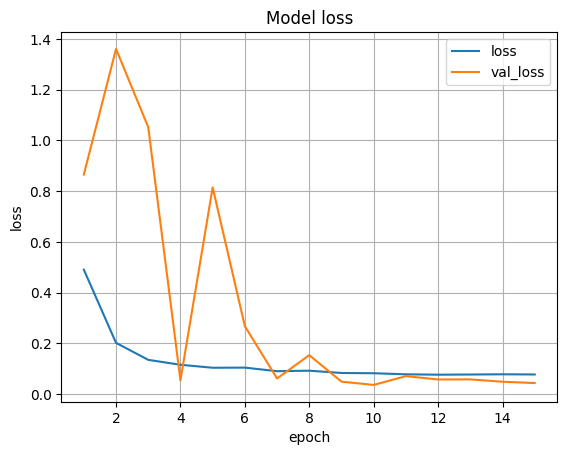

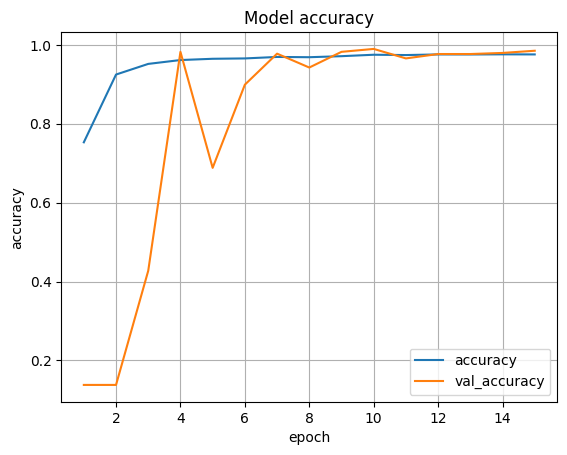

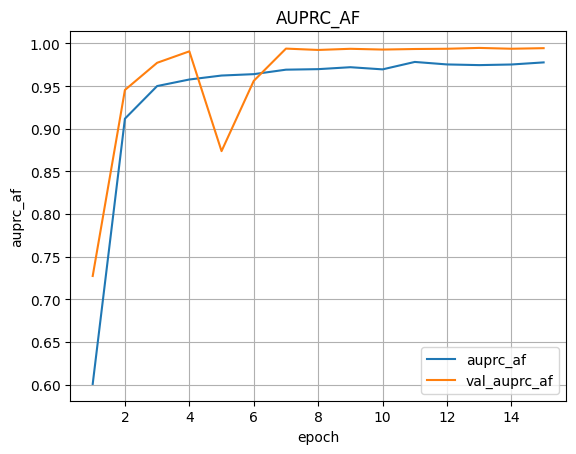

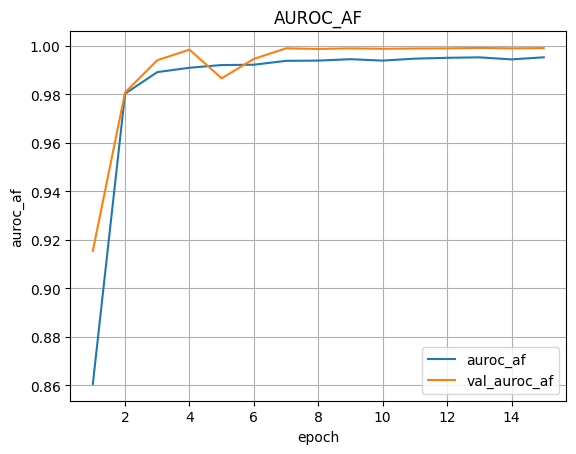

Best val_auprc_af: 0.9948 at epoch 13
  val_accuracy at best: 0.9769
  val_loss at best: 0.0576


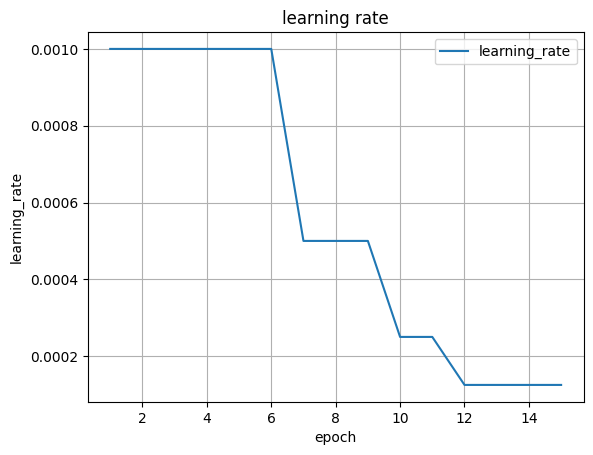

In [56]:
import matplotlib.pyplot as plt
import numpy as np

h = history.history  # dict: 'loss','accuracy','val_loss','val_accuracy', ...
# Số epoch an toàn (dựa vào key dài nhất)
epochs_len = max(len(v) for v in h.values())
epochs = np.arange(1, epochs_len + 1)

def plot_pair(metric_name, ylabel=None, title=None):
    tr = metric_name
    va = f"val_{metric_name}"
    if tr in h and va in h:
        plt.figure()
        plt.plot(epochs, h[tr], label=tr)
        plt.plot(epochs, h[va], label=va)
        plt.title(title or metric_name)
        plt.xlabel("epoch"); plt.ylabel(ylabel or metric_name)
        plt.legend(); plt.grid(True)
        plt.show()
        return True
    return False

# Loss & Accuracy
plot_pair("loss", ylabel="loss", title="Model loss")
plot_pair("accuracy", ylabel="accuracy", title="Model accuracy")

# AF-specific metrics (nếu đã dùng cell T2 mới: auprc_af/auroc_af)
found = []
for m in ["auprc_af", "auroc_af", "auprc", "auroc"]:
    if plot_pair(m, ylabel=m, title=m.upper()):
        found.append(m)

# In best epoch theo AUPRC (ưu tiên lớp AF)
monitor = None
for key in ["val_auprc_af", "val_auprc"]:
    if key in h:
        monitor = key
        break

if monitor is not None:
    best_idx = int(np.argmax(h[monitor]))
    print(f"Best {monitor}: {h[monitor][best_idx]:.4f} at epoch {best_idx+1}")
    if "val_accuracy" in h:
        print(f"  val_accuracy at best: {h['val_accuracy'][best_idx]:.4f}")
    if "val_loss" in h:
        print(f"  val_loss at best: {h['val_loss'][best_idx]:.4f}")

# (Tuỳ) Vẽ learning rate nếu có log
lr_key = "lr" if "lr" in h else ("learning_rate" if "learning_rate" in h else None)
if lr_key:
    plt.figure()
    plt.plot(epochs, h[lr_key], label=lr_key)
    plt.title("learning rate"); plt.xlabel("epoch"); plt.ylabel(lr_key)
    plt.legend(); plt.grid(True)
    plt.show()


Đánh giá trên TEST

In [57]:
# CELL T6b — Chọn threshold từ validation rồi áp lên test (AF = cột 1)
import numpy as np, tensorflow as tf, keras
from sklearn.metrics import (
    roc_curve, roc_auc_score, average_precision_score,
    precision_recall_curve, confusion_matrix
)

# Load full model (không cần compile/metrics)
try:
    mdl_tiny = keras.saving.load_model('weights/tiny_leadI_full.keras', compile=False, safe_mode=False)
except Exception:
    mdl_tiny = tf.keras.models.load_model('weights/tiny_leadI_full.keras', compile=False)

def collect_preds(ds):
    y_true, y_prob = [], []
    for X, y in ds:
        # y one-hot [NORM, AF], lấy cột 1
        y_true.append(y[:, 1])
        y_prob.append(mdl_tiny.predict(X, verbose=0)[:, 1])
    return np.concatenate(y_true), np.concatenate(y_prob)

# --- Validation: lấy ngưỡng ---
yv, pv = collect_preds(val_tiny)

# AUCs trên VAL (không phụ thuộc ngưỡng)
val_auroc = roc_auc_score(yv, pv)
val_auprc = average_precision_score(yv, pv)
print(f"[VAL] AUROC={val_auroc:.4f} | AUC-PR={val_auprc:.4f}")

# ROC-based Youden
fpr, tpr, thr = roc_curve(yv, pv)
valid = np.isfinite(thr)
youden_idx = np.argmax((tpr - fpr)[valid])
thr_youden_val = thr[valid][youden_idx]
print(f"[VAL] Youden threshold = {thr_youden_val:.4f}")

# Threshold đạt recall >= 0.95
idxs = np.where(tpr >= 0.95)[0]
if len(idxs) > 0:
    j = idxs.min()
    # tránh thr[0] = inf
    thr_rec95 = thr[j] if np.isfinite(thr[j]) else thr[min(j+1, len(thr)-1)]
else:
    thr_rec95 = 0.5
print(f"[VAL] Threshold for recall>=0.95 = {thr_rec95:.4f}")

# F1-max theo PR
prec, rec, thr_pr = precision_recall_curve(yv, pv)  # thr_pr có len = len(prec)-1
f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
thr_f1 = thr_pr[np.nanargmax(f1)]
print(f"[VAL] Threshold for F1-max = {thr_f1:.4f}")

# --- Test (đánh giá ngưỡng) ---
yt, pt = collect_preds(test_tiny)

# AUCs trên TEST (không phụ thuộc ngưỡng)
test_auroc = roc_auc_score(yt, pt)
test_auprc = average_precision_score(yt, pt)
print(f"\n[TEST] AUROC={test_auroc:.4f} | AUC-PR={test_auprc:.4f}")

def eval_on_test(th):
    pred = (pt >= th).astype(int)
    cm = confusion_matrix(yt, pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    acc  = (tp + tn) / cm.sum()
    prec = tp / (tp + fp + 1e-12)
    rec  = tp / (tp + fn + 1e-12)
    f1   = 2 * prec * rec / (prec + rec + 1e-12)
    print(f"\n[TEST] @thr={th:.4f}  ACC={acc:.4f}  PREC={prec:.4f}  REC={rec:.4f}  F1={f1:.4f}")
    print("CM [[TN FP]\n    [FN TP]] =\n", cm)

for th in [thr_youden_val, thr_rec95, thr_f1]:
    eval_on_test(th)


/home/cuong/root_data/ai_cnn_env/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ecg
Received: inputs=['Tensor(shape=(32, 1000, 1))']
  warnings.warn(msg)


[VAL] AUROC=0.9991 | AUC-PR=0.9949
[VAL] Youden threshold = 0.6518
[VAL] Threshold for recall>=0.95 = 0.8898
[VAL] Threshold for F1-max = 0.7885

[TEST] AUROC=0.9957 | AUC-PR=0.9663

[TEST] @thr=0.6518  ACC=0.9749  PREC=0.8547  REC=0.9800  F1=0.9130
CM [[TN FP]
    [FN TP]] =
 [[939  25]
 [  3 147]]

[TEST] @thr=0.8898  ACC=0.9829  PREC=0.9396  REC=0.9333  F1=0.9365
CM [[TN FP]
    [FN TP]] =
 [[955   9]
 [ 10 140]]

[TEST] @thr=0.7885  ACC=0.9838  PREC=0.9231  REC=0.9600  F1=0.9412
CM [[TN FP]
    [FN TP]] =
 [[952  12]
 [  6 144]]



=== Confusion matrices & metrics on TEST ===

--- Threshold = 0.6518 ---


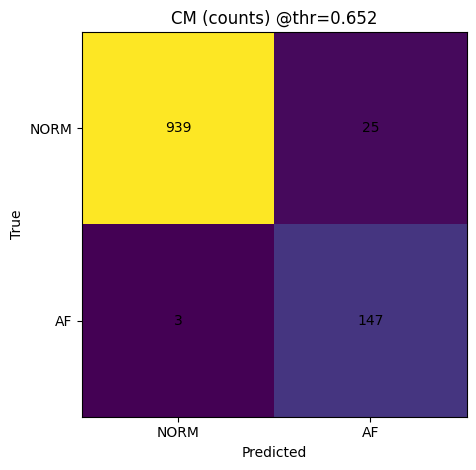

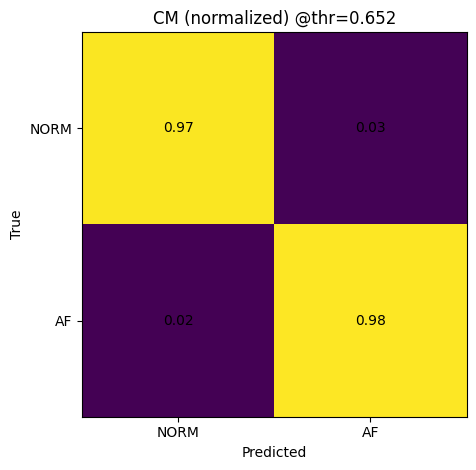

ACC=0.9749  PREC=0.8547  REC=0.9800  SPEC=0.9741  BAL_ACC=0.9770  F1=0.9130

--- Threshold = 0.8898 ---


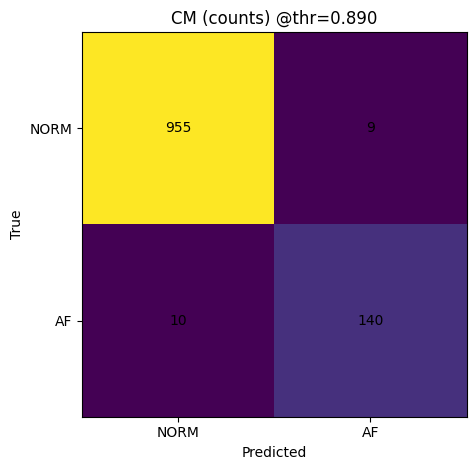

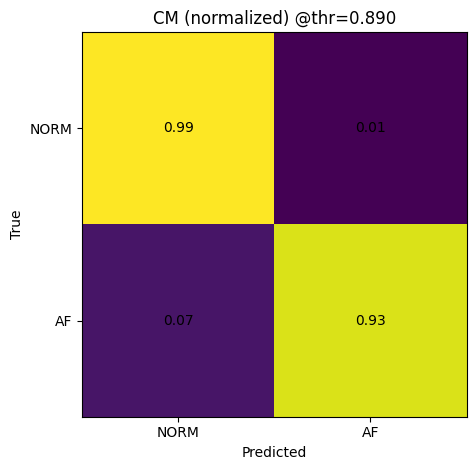

ACC=0.9829  PREC=0.9396  REC=0.9333  SPEC=0.9907  BAL_ACC=0.9620  F1=0.9365

--- Threshold = 0.7885 ---


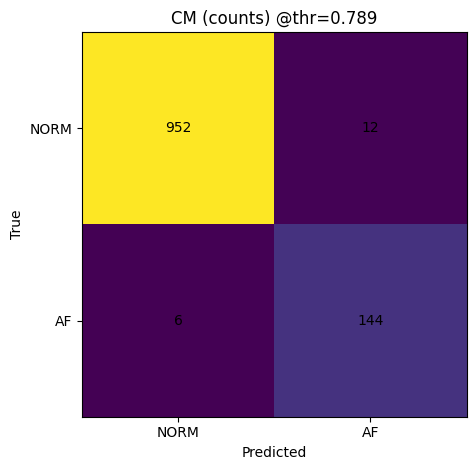

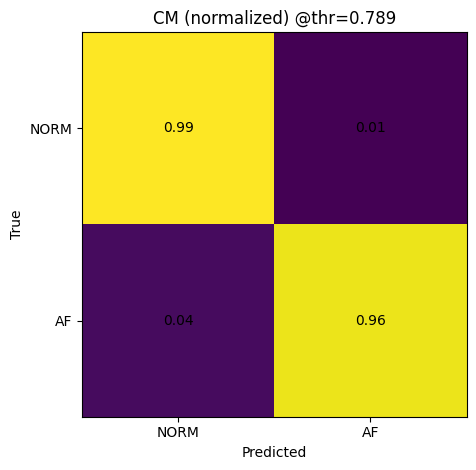

ACC=0.9838  PREC=0.9231  REC=0.9600  SPEC=0.9876  BAL_ACC=0.9738  F1=0.9412


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_cm_from_scores(y_true, y_prob, th, normalize=False, title=None):
    pred = (y_prob >= th).astype(int)
    cm = confusion_matrix(y_true, pred, labels=[0, 1])

    if normalize:
        M = cm.astype(np.float64) / (cm.sum(axis=1, keepdims=True) + 1e-12)
        fmt = ".2f"
        suffix = " (normalized)"
    else:
        M = cm
        fmt = "d"
        suffix = " (counts)"

    plt.figure()
    plt.imshow(M, interpolation="nearest")
    plt.title(title or f"Confusion matrix @thr={th:.3f}{suffix}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    ticks = np.arange(2)
    plt.xticks(ticks, ["NORM", "AF"]); plt.yticks(ticks, ["NORM", "AF"])

    # annotate
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(M[i, j], fmt), ha="center", va="center")
    plt.tight_layout()
    plt.show()
    return cm

def metrics_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    acc  = (tp + tn) / cm.sum()
    prec = tp / (tp + fp + 1e-12)
    rec  = tp / (tp + fn + 1e-12)
    spec = tn / (tn + fp + 1e-12)   # specificity (true negative rate)
    bal  = 0.5 * (rec + spec)       # balanced accuracy
    f1   = 2 * prec * rec / (prec + rec + 1e-12)
    return acc, prec, rec, spec, bal, f1

print("\n=== Confusion matrices & metrics on TEST ===")
for th in [thr_youden_val, thr_rec95, thr_f1]:
    print(f"\n--- Threshold = {th:.4f} ---")
    cm_counts = plot_cm_from_scores(yt, pt, th, normalize=False, title=f"CM (counts) @thr={th:.3f}")
    _         = plot_cm_from_scores(yt, pt, th, normalize=True,  title=f"CM (normalized) @thr={th:.3f}")

    acc, prec, rec, spec, bal, f1 = metrics_from_cm(cm_counts)
    print(f"ACC={acc:.4f}  PREC={prec:.4f}  REC={rec:.4f}  SPEC={spec:.4f}  BAL_ACC={bal:.4f}  F1={f1:.4f}")
